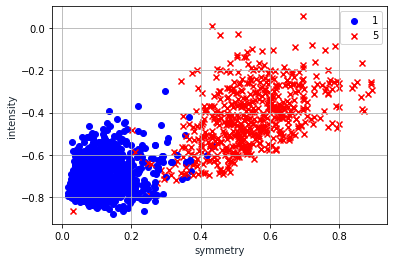

In [1]:
import pandas as pd
from matplotlib import pyplot

#importing test and training sets

testFile = open("./Digits/ZipDigits.test")
test = testFile.read()

trainFile = open("./Digits/ZipDigits.train")
train = trainFile.read()

#preprocessing: splitting by rows (individual digits' data)
test_rows_raw = test.split('\n')
test_rows_raw.pop(2007)
test_rows = []

train_rows_raw = train.split('\n')
train_rows_raw.pop(len(train_rows_raw)-1)
train_rows = []

#preprocessing: splitting data within each digits' set and saving only data for '1' and '5', labeled as 1 and -1 
#respectively
for i in range(0, len(test_rows_raw)):
    if test_rows_raw[i][0][0] == '5' or test_rows_raw[i][0][0] == '1':
        split = test_rows_raw[i].split(' ')
        if test_rows_raw[i][0][0] == '5':
            split[0] = -1.0
        else:
            split[0] = 1.0
        test_rows.append(split[0:257])


for j in range(0, len(train_rows_raw)):
    if train_rows_raw[j][0][0] == '5' or train_rows_raw[j][0][0] == '1':
        split = train_rows_raw[j].split(' ')
        if train_rows_raw[j][0][0] == '5':
            split[0] = -1.0
        else:
            split[0] = 1.0
        train_rows.append(split[0:257])
        
#extracting symmetry and intensity features for training set
for z in range(0,len(train_rows)):
    tot_sym = 0
    tot_int = 0
    #matrices used to store left and right halves of each digit
    left_train = [[0] * 8 for _ in range(16)]
    right_train = [[0] * 8 for _ in range(16)]
    #loop over rows of each digit
    for x in range(0,16):
        #loop through each pixel on each row and store in left and right halves, sum up vals for intensity
        for y in range(0,16):
            tot_int += float(train_rows[z][16*x+y+1])
            if y < 8:
                left_train[x][y] = float(train_rows[z][16*x+y+1])
            else:
                right_train[x][y-8] = float(train_rows[z][16*x+y+1])
        #compare left and right halves for each pixel in a row, keep total absolute values of differences
        for i in range(0,8):
            tot_sym += abs(left_train[x][i] - right_train[x][7-i])
    #getting the final symmetry value for each image
    sym = tot_sym/128
    #getting the final intensity value for each image
    intens = tot_int/256
    #appending extracted values to data
    train_rows[z].append(sym)
    train_rows[z].append(intens)

    
#extracting symmetry and intensity features for test set
for z in range(0,len(test_rows)):
    tot_sym = 0
    tot_int = 0
    #matrices used to store left and right halves of each digit
    left_test = [[0] * 8 for _ in range(16)]
    right_test = [[0] * 8 for _ in range(16)]
    #loop over rows of each digit
    for x in range(0,16):
        #loop through each pixel on each row and store in left and right halves, sum up vals for intensity
        for y in range(0,16):
            tot_int += float(test_rows[z][16*x+y+1])
            if y < 8:
                left_test[x][y] = float(test_rows[z][16*x+y+1])
            else:
                right_test[x][y-8] = float(test_rows[z][16*x+y+1])
        #compare left and right halves for each pixel in a row, keep total absolute values of differences
        for i in range(0,8):
            tot_sym += abs(left_test[x][i] - right_test[x][7-i])
    #getting the final symmetry value for each image
    sym = tot_sym/128
    #getting the final intensity value for each image
    intens = tot_int/256
    #appending extracted values to data
    test_rows[z].append(sym)
    test_rows[z].append(intens)
    
#rest of code is plotting points
#plotting symmetry (x-axis) by intensity (y-axis) in scatter.  Marking differently based on whether a '1' or '5'
for r in range(0, len(train_rows)):
    if train_rows[r][0] == 1:
        one = pyplot.scatter(train_rows[r][257], train_rows[r][258], marker = 'o', color = 'blue', label = '1')
    else:
        five = pyplot.scatter(train_rows[r][257], train_rows[r][258], marker = 'x', color = 'red', label = '5')

pyplot.xlabel('symmetry', color='#1C2833')
pyplot.ylabel('intensity', color='#1C2833')
pyplot.legend((one, five),
          ('1', '5'),
          loc = 'best')
pyplot.grid()
pyplot.show()


In [2]:
#Neural Network implementation (forward propagation and back propagation for 
#                                   2-layers with hidden layer containing m neurons)
import numpy as np

#forward propagation algorithm 
def forProp(x_data, m=3, w=[0]):
    #if running for first time, initialize W^1 to small random non-zero values, so that tanh(w^Tx) is close to 0
    #initialize so weights match up with number of neurons in the hidden layer
    if len(w) < 2:
        w_bot = []
        w_mid = []
        w_top = []
        for i in range(0,m-1):
            w_top.append(0.0004)
            w_mid.append(-0.0002/x_data[0])
            w_bot.append(-0.0001/x_data[1])
        w.append([w_top, w_mid, w_bot])

    #set x for layer 0 (input layer)
    x = [[1, x_data[0], x_data[1]]]
    s = [[0]]
    for l in range(1,3):
        #calculate s for each layer
        s.append(np.dot(np.array(w[l]).T, np.array(x[l-1])))
        
        #use tanh activation function to obtain x, and add 1 in front representing bias neuron if not at last layer
        next_x = np.tanh(s[l]).tolist()
        if l != 2:
            next_x.insert(0,1)
        x.append(next_x)
        
        #initialize W^2 if first time running
        if(len(w)<3):
            next_w = []
            for i in range(0, m):
                if i == 0:
                    next_w.append(((m+1)*0.0001)/x[l][i])
                else:
                    next_w.append(((m-i)*(-0.0001))/x[l][i])
            w.append(next_w)

    return s, x, w

#Backpropagation to compute sensitivities d^l
def backProp(x_data, y_data, m=3, w = [0]):
    #get s, x, and w (if not initialized) from forward propagation
    s, x, w = forProp(x_data, m, w)

    d = [0,0,0]
    
    #calculate d^L
    d[2] = 2*(x[2] - y_data)*(1-x[2]*x[2])

    #calculate the derivative of the activation function used in back prop for layer L
    x_b = x[1][1:]
    tpsl = [1 - x_b * x_b for x_b,x_b in zip(x_b,x_b)]

    #calculate the back-prop "input" to the hidden layer (multiply weight and sensitivity of layer in front)
    w_b = w[2][1:]
    right = [a*d[2] for a in w_b]
    
    #get the sensitivity value of the hidden layer
    d[1] = [tpsl*right for tpsl,right in zip(tpsl,right)]
    
    return x,d

In [3]:
#4 Gradient Descent implementation
import itertools

def gD(D, m=10, w = [0]):
    #initialize E_in, G
    E_in = 0
    
    #G initialized specifically to correspond to shape of this neural network
    G = [0,[0,0,0],0]
    
    
    for n in range(0, len(D)):
        #get x values from forward prop and sensitivities d from backProp (calling backProp calls both sequentially)
        x, d = backProp(D[n][0:2], D[n][2], m, w)
        
        #using sign function on output layer to determine E_in
        if (x[2]>0 and D[n][2]<0) or (x[2]<0 and D[n][2]>0):
            E_in = E_in+1

        for l in range(1, 3):
            Gx = np.multiply(np.array(x[l-1]).reshape(-1,1), np.array(d[l]).reshape(1,-1)).tolist()
            
            #we have 2 units (not including bias) at the input layer and m units in the hidden layer.  
            #Thus W[1] will have 3 lists containing m-1 weights each.  To add the gradient, we have to 
            #explicitly shape our gradient similarly which the following code does
            if l == 1:     
                #if this is the first data point in this iteration, our G[1] does not contain 3 lists yet
                if type(G[l][0]) != list:
                    #specialized Python syntax to add lists w/o errors
                    #accounts for 3 lists in the first layer
                    for sp in range(0,3):     
                        G[l][sp] = [G[l][sp] + (1/len(D))*g_new for g_new in Gx[sp]]
                else:
                    #specialized Python syntax to add lists w/o errors
                    #accounts for 3 lists in the first layer
                    for sp in range(0,3):     
                        G[l][sp] = [g_old + (1/len(D))*g_new for g_old, g_new in zip(G[l][sp],Gx[sp])]
            else:
                #if we are in layer 2, W[2] is a single list of m weights.  We use the following
                #itertools library to concatenate the Gx[2] values into a single list
                Gx = list(itertools.chain.from_iterable(Gx))
                
                #same procedure as above
                if type(G[l]) != list:
                    G[l] = [G[l] + (1/len(D))*g_new for g_new in Gx]
                else:
                    G[l] = [g_old + (1/len(D))*g_new for g_old, g_new in zip(G[l],Gx)]
    E_in = E_in/len(D)
    return E_in, G, w

In [4]:
#5.1 Vanilla gradient descent on training set (all samples)

#format data in list of [sym, intensity, class] for each training example to pass into gradient descent
nnD = []
for t in range(0,len(train_rows)):
    samp = []
    samp.append(train_rows[t][257])
    samp.append(train_rows[t][258])
    samp.append(train_rows[t][0])
    nnD.append(samp)

gD(nnD)

(0.3382447149263293,
 [0,
  [[4.961762797937069,
    4.410455820388514,
    3.85914884283996,
    3.3078418652913872,
    2.7565348877428204,
    2.205227910194257,
    1.6539209326456936,
    1.1026139550971286,
    0.5513069775485643],
   [-2.222294089910811,
    -1.9753725243651685,
    -1.7284509588195232,
    -1.4815293932738758,
    -1.2346078277282313,
    -0.9876862621825843,
    -0.7407646966369379,
    -0.49384313109129213,
    -0.24692156554564607],
   [-5.2931553564407965,
    -4.705026983502932,
    -4.116898610565057,
    -3.5287702376271888,
    -2.940641864689334,
    -2.352513491751466,
    -1.7643851188135944,
    -1.176256745875733,
    -0.5881283729378665]],
  [-0.5513070431178966,
   0.00021329442399121393,
   0.00021329442399121393,
   0.00021329442399121393,
   0.00021329442399121393,
   0.00021329442399121393,
   0.00021329442399121393,
   0.00021329442399121393,
   0.00021329442399121393,
   0.00021329442399121393]],
 [0,
  [[0.0004, 0.0004, 0.0004, 0.0004, 0.0

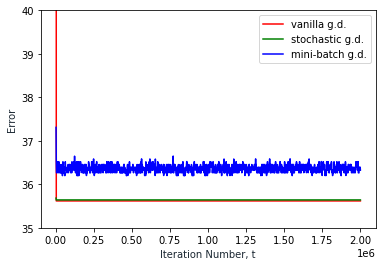

In [20]:
#5.4 Plot E_in for each experiment for 2*10^6 iterations
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

t_data = []

#error data for each experiment
Eo_data = []
Ev_data = []

#when we pass in this initial weight, forward propagation automatically initializes on the first iteration of gradient
#descent.  initialized different weight vectors for each experiment
wv = [0]
ws = [0]
wm = [0]

E_ins = 0
E_inm = 0

#fixed learning rate
eta = 0.05

#num. nodes in hidden layer
m = 10

#iteration var
t = 0

while t<=2000000:
    E_inv, Gv, wv = gD(nnD[::-1], m, wv)
    #update weight after one full cycle through vanilla gradient descent
    for l in range(1,3):
        if l == 1:     
            #specialized Python syntax to add lists w/o errors
            #accounts for 3 lists in the first layer
            for sp in range(0,3):
                Gv[l][sp] = [raw*eta for raw in Gv[l][sp]]
                wv[l][sp] = [w_old - g for w_old,g in zip(wv[l][sp], Gv[l][sp])]
        else:
            #if we are in layer 2, W[2] and G[2] are a single list of m weights or gradients, respectively
            wv[l] = [w_old - eta*g for w_old,g in zip(wv[l],Gv[l])]
    Ev_data.append(E_inv*100)
    
    #create random order of data to feed into s.g.d. and batch s.g.d.
    order = []
    while len(order) < len(nnD):
        samp = random.randint(0,len(nnD)-1)
        if samp not in order:
            order.append(samp)

    #one iteration through s.g.d: all data points fed once in random order
    for b in order:
        E_inx, ws = sgD([nnD[b]], m, eta, ws)
        E_ins = E_ins + E_inx
    
    E_ins = E_ins/len(nnD)
    Es_data.append(E_ins*100)
    
    
    
    batch_size = 32

    #initialize container to hold batches
    batches = [[] for ay in range(0,math.ceil(len(nnD)/32))]

    o=0
    while o < len(nnD):
        for q in range(0, len(batches)):
            #append random data point to each batch, stop when all data points assigned
            batches[q].append(nnD[order[o]])
            o=o+1
            if o == len(nnD):
                break

    #if some batches not allocated full batch_size due to undivisible number of samples, fix by adding random
    #points from data set until all batches of equal size
    for b in batches:
        while len(b) < batch_size:
            o = random.randint(0,len(nnD)-1)
            b.append(nnD[o])

    for q in range(0, len(batches)):
        E_inb, Gm, wm = mbgD(batches[q], m, wm)
        #update weight based on batch gradient from one batch
        for l in range(1,3):
            if l == 1:     
                #specialized Python syntax to add lists w/o errors
                #accounts for 3 lists in the first layer
                for sp in range(0,3):
                    Gm[l][sp] = [raw*eta for raw in Gm[l][sp]]
                    wm[l][sp] = [w_old - g for w_old,g in zip(wm[l][sp], Gm[l][sp])]
            else:
                #if we are in layer 2, W[2] and G[2] are a single list of m weights or gradients, respectively
                wm[l] = [w_old - eta*g for w_old,g in zip(wm[l],Gm[l])]
        E_inm = E_inm + E_inb
    
    E_inm = E_inm/len(batches)
    Em_data.append(E_inm*100)
    t = t + len(nnD)
    t_data.append(t)
    

#plotting error measures vs. iteration for each of the 3 experiments
plt.plot(t_data, Ev_data, '-r')
plt.plot(t_data, Es_data, '-g')
plt.plot(t_data, Em_data, '-b')
van = mlines.Line2D([], [], color='red', label='vanilla g.d.')
stoch = mlines.Line2D([], [], color='green', label='stochastic g.d.')
batch = mlines.Line2D([], [], color='blue', label='mini-batch g.d.')
plt.xlabel('Iteration Number, t', color='#1C2833')
plt.ylabel('Error', color='#1C2833')
plt.legend((van, stoch, batch),
          ('vanilla g.d.', 'stochastic g.d.', 'mini-batch g.d.'),
          loc = 'best')
axes = plt.gca()
axes.set_ylim([35,40])
plt.show()

In [21]:
#5.5 calculate test error for each experiment

#initialize error measures for each experiment type
Ev_test = 0
Es_test = 0
Em_test = 0

#format data in list of [sym, intensity, class] for each test example to pass into forward propagation
nnT = []
for t in range(0,len(test_rows)):
    samp = []
    samp.append(test_rows[t][257])
    samp.append(test_rows[t][258])
    samp.append(test_rows[t][0])
    nnT.append(samp)

for z in range(0, len(nnT)):
    #get x values from forward prop for each experiment
    s, xv, wv = forProp(nnT[z][0:2], m, wv)
    s, xs, ws = forProp(nnT[z][0:2], m, ws)
    s, xm, wm = forProp(nnT[z][0:2], m, wm)
        
    #using sign function on output layer to determine if error made on classification, for each experiment
    if (xv[2]>0 and nnT[z][2]<0) or (xv[2]<0 and nnT[z][2]>0):
        Ev_test = Ev_test+1
    if (xs[2]>0 and nnT[z][2]<0) or (xs[2]<0 and nnT[z][2]>0):
        Es_test = Es_test+1
    if (xm[2]>0 and nnT[z][2]<0) or (xm[2]<0 and nnT[z][2]>0):
        Em_test = Em_test+1

Ev_test = Ev_test/len(nnT)
Es_test = Es_test/len(nnT)
Em_test = Em_test/len(nnT)

print("Error of vanilla g.d. on test set: " + str(Ev_test*100) + "%")
print("Error of stochastic g.d. on test set: " + str(Es_test*100) + "%")
print("Error of mini-batch g.d. on test set: " + str(Em_test*100) + "%")

Error of vanilla g.d. on test set: 37.735849056603776%
Error of stochastic g.d. on test set: 37.735849056603776%
Error of mini-batch g.d. on test set: 37.735849056603776%
